In [1]:
from math import sqrt
import time

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, preprocessing, model_selection
from sklearn.metrics import mean_squared_error


from activation import fun_dict


In [6]:
def load_dataset():
    """
    Load data from Boston housing regression.
    :return: data scaled and target.
    """
    x, y = datasets.load_breast_cancer(return_X_y=True)
    x = preprocessing.scale(x)
    y = y.reshape(len(y), 1)
    return x, y

def rmse(a, b):
    """
    Root Mean Squared Error metric.
    :param a:
    :param b:
    :return: RMSE value
    """
    return sqrt(mean_squared_error(a, b)) 


In [9]:
import numpy as np
import pickle
from graphviz import Digraph
class NeuralNetwork:
    """
    Neural Network.
    """
    def __init__(self, seed=None):
        np.random.seed(seed)

    def get_layers(self):
        self.get_input_layer()
        self.get_output_layer()

    def get_input_layer(self):
        self.input_weight = np.random.random((self.dim, self.neurons)) * 2.0 - 1.0
        self.bias_input_layer = np.zeros((self.neurons, 1))

    def get_output_layer(self):
        self.output_weight = np.random.random((self.neurons, 1))  * 2.0 - 1.0
        self.bias_output_layer = np.zeros((self.t, 1))

    def initial(self, x, y, max_iter, neurons, learning_rate, neuronal_fun, fun_dict):
        self.dim = x.shape[1]
        self.t = y.shape[1]
        self.max_iter = max_iter
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.activation = fun_dict[neuronal_fun]['activation']
        self.activation_der = fun_dict[neuronal_fun]['derivative']
        self.get_layers()
        return self


    def train(self, x, y,
              max_iter: int = 1000,
              neurons: int = 10,
              learning_rate: float = 1.0,
              neuronal_fun='sigmoid'):
        """
        Train the neural network with gradient descent.
        :param x: numpy.array with data (intances and features).
        :param y: numpy.array with the target to predict.
        :param int max_iter: number of iterations for training.
        :param int neurons: number of neurons in the hidden layer.
        :param float learning_rate: step to add in each iteration.
        :param str neuronal_fun: function for activation functions in 
        """
        self.initial(x=x,
                     y=y,
                     max_iter=max_iter,
                     neurons=neurons,
                     learning_rate=learning_rate,
                     neuronal_fun=neuronal_fun)

        for iteration in range(self.max_iter):
            # print('Iteration =', iteration)
            self.backward(x, y)
            
    def train(self, x, y, max_iter=500, neurons=5, learning_rate=0.01, neuronal_fun='sigmoid', fun_dict=None):
        self.initial(x=x, y=y, max_iter=max_iter, neurons=neurons, learning_rate=learning_rate, neuronal_fun=neuronal_fun, fun_dict=fun_dict)
        for iteration in range(self.max_iter):
            self.backward(x, y)

    def backward(self, x, y, penalty=0):
        hidden_layer, output_layer = self.forward(x)
        error = output_layer - y
        nc_error = error + penalty

        output_delta = nc_error * self.activation_der(self.temp_o)
        self.bias_output_layer -= np.mean(self.learning_rate * output_delta)
        self.output_weight -= self.learning_rate * np.dot(hidden_layer.T, output_delta)

        hidden_delta = np.dot(output_delta, self.output_weight.T) * self.activation_der(self.temp_h)
        self.bias_input_layer -= np.mean(self.learning_rate * hidden_delta, axis=0).reshape(self.neurons, 1)
        self.input_weight -= self.learning_rate * np.dot(x.T, hidden_delta)

    def forward(self, x_test):
        self.temp_h = np.dot(x_test, self.input_weight) + self.bias_input_layer.T
        hidden_layer = self.activation(self.temp_h)
        self.temp_o = np.dot(hidden_layer, self.output_weight) + self.bias_output_layer.T
        output_layer = self.activation(self.temp_o)
        return hidden_layer, output_layer

    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

    def predict(self, x_test):
        _, output_layer = self.forward(x_test)
        return output_layer

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
        
    

class NCL:
    def __init__(self):
        self.base_learner = []
        self.rmse_array = None

    def visualize(self, file_path='ncl_ensemble', node_size=0.1, graph_size=100, horizontal_spacing=10):
        dot = Digraph()

        # horisontal position
        dot.attr(rankdir='LR')
        dot.attr(size=f'{graph_size},{graph_size}!')
        
        dot.attr(ranksep=str(horizontal_spacing))

        for i, learner in enumerate(self.base_learner):
            dot.node(f'Learner {i}', label=f'Learner {i}', shape='ellipse')
            learner_dot = Digraph()

            # Horizontal position
            learner_dot.attr(rankdir='LR')

            # Input layer
            for j in range(learner.dim):
                learner_dot.node(f'Input {j}', shape='circle', width=str(node_size), height=str(node_size))

            # Hidden layer
            for k in range(learner.neurons):
                learner_dot.node(f'Hidden {k}', shape='circle', width=str(node_size), height=str(node_size))

            # Output layer
            learner_dot.node('Output', shape='circle', width=str(node_size), height=str(node_size))

            # Input to hidden layer connections
            for j in range(learner.dim):
                for k in range(learner.neurons):
                    learner_dot.edge(f'Input {j}', f'Hidden {k}', label=f'{learner.input_weight[j, k]:.2f}')

            # Hidden to output layer connections
            for k in range(learner.neurons):
                learner_dot.edge(f'Hidden {k}', 'Output', label=f'{learner.output_weight[k, 0]:.2f}')

            learner_dot.render(f'{file_path}_learner_{i}', format='png', cleanup=True)
            dot.subgraph(learner_dot)

        dot.render(file_path, format='png', cleanup=True)
    
    def train(self, x, y, size, neurons, max_iter, lambda_, learning_rate, neural_fun='sigmoid', fun_dict=None):
        self.size = size
        self.max_iter = max_iter
        self.lambda_ = lambda_
        self.base_learner = [NeuralNetwork(seed=s).initial(x=x, y=y, neurons=neurons, learning_rate=learning_rate, neuronal_fun=neural_fun, max_iter=max_iter, fun_dict=fun_dict)
                             for s in range(self.size)]

        self.rmse_array = np.inf * np.ones(self.max_iter)

        for iteration in range(self.max_iter):
            f_bar = self.predict(x)
            for s in range(self.size):
                penalty = self.lambda_ * (self.base_learner[s].predict(x) - f_bar)
                self.base_learner[s].backward(x, y, penalty)
            self.rmse_array[iteration] = np.sqrt(np.mean((f_bar - y) ** 2))

    def predict(self, x):
        f_bar = np.mean([learner.predict(x) for learner in self.base_learner], axis=0)
        return f_bar

    def save_model(self, file_path):
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)

Train =  512
Test =  57
Colums =  30
Train time = 8.42895850003697
Test  time= 0.0007095999899320304
RMSE lambda = 0: 0.08909005706343319
RMSE lambda = 1: 0.08724755052429362


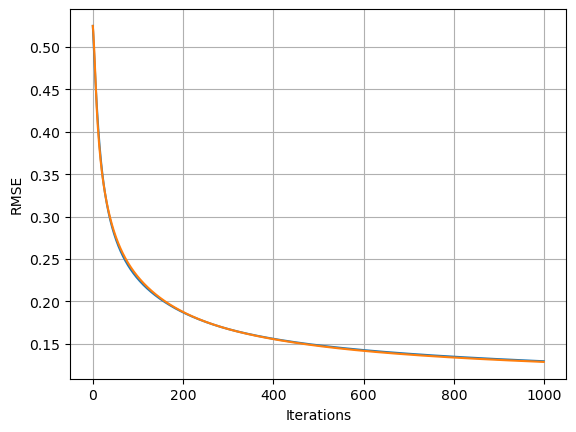

In [14]:
# Load dataset
x, y = load_dataset()
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.1, random_state=0)
print('Train = ',  x_train.shape[0])
print('Test = ',   x_test.shape[0])
print('Colums = ', x_train.shape[1])

# Train params
max_iter = 1000
size = 10
h = 10
learning_rate = 0.001

# Create model
ncl1 = NCL()
ncl2 = NCL()

# Train
ncl1.train(x, y, size=size, neurons=h, max_iter=max_iter, lambda_= 0, learning_rate=learning_rate, neural_fun='sigmoid', fun_dict=fun_dict)
train_time_start = time.perf_counter()
ncl2.train(x, y, size=size, neurons=h, max_iter=max_iter, lambda_= 4, learning_rate=learning_rate, neural_fun='sigmoid', fun_dict=fun_dict)
train_time_end = time.perf_counter()

# Test
pred1 = ncl1.predict(x_test)
test_time_start = time.perf_counter()
pred2 = ncl2.predict(x_test)
test_time_end = time.perf_counter()

# Model save
ncl2.save_model('ncl_ensemble.pkl')

# Train time
print('Train time =', train_time_end - train_time_start)
print('Test  time=', test_time_end - test_time_start)

# RMSE
rmse_value1 = rmse(pred1, y_test)
rmse_value2 = rmse(pred2, y_test)
print('RMSE lambda = 0:', rmse_value1)
print('RMSE lambda = 1:', rmse_value2)

# plot results
plt.plot(ncl1.rmse_array)
plt.plot(ncl2.rmse_array)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [8]:
# Load model
loaded_ncl = NCL.load_model('ncl_ensemble.pkl')

# Test model
pred= loaded_ncl.predict(x_test)
rmse_value = rmse(pred, y_test)
print('RMSE =', rmse_value)

RMSE = 0.08830453507824888
